In [2]:
import numpy as np
import pandas as pd
import missingno as msno

<AxesSubplot: >

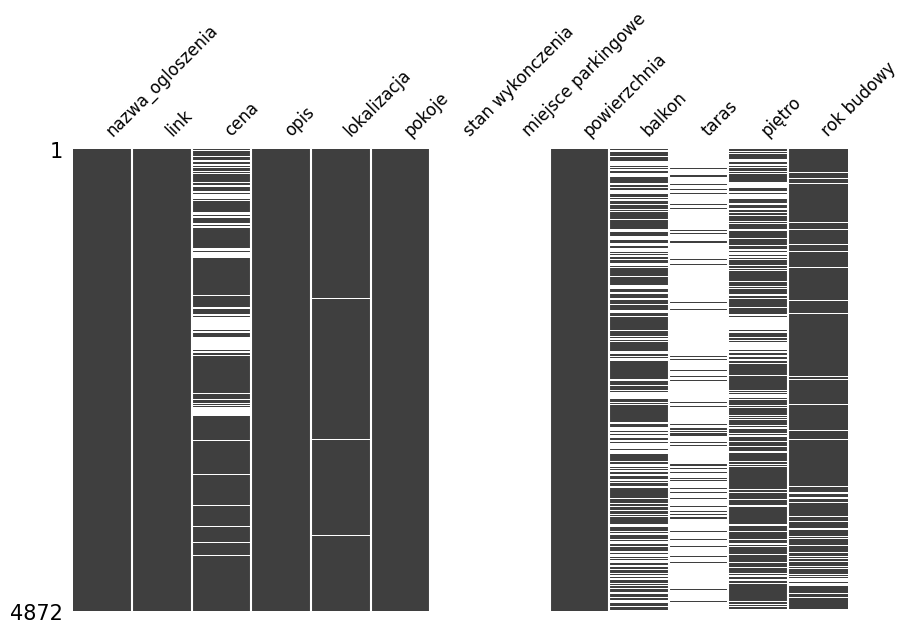

In [4]:
data0 = pd.read_csv('./morizon_40_80.csv')
data1 = pd.read_csv('./morizon_11_40.csv')
data2 = pd.read_csv('./morizon_1_10.csv')
data3 = pd.read_csv('./morizon_last.csv')
data = pd.concat([data0, data1, data2, data3], ignore_index=True)
# see missing values
msno.matrix(data, figsize=(10, 6), sparkline=False, fontsize=12)

In [ ]:
data = data[~data.powierzchnia.isna()].drop_duplicates()
data.head()

In [6]:
### fillna, cosmetic string changes, extracting street
data['stan wykonczenia'] = data['stan wykonczenia'].fillna('do remontu')
data['lokalizacja'] = data['lokalizacja'].str.replace(',', '')
data_raw = data.copy()

colnames = ['cena', 'powierzchnia']
replace_dict = {'zł': '', 'm²': '', ' ': ''}

data_raw[colnames] = data_raw[colnames].astype('str')
data_raw[colnames] = data_raw[colnames].applymap(lambda x: str(x).replace('zł', '').replace('m²', '').replace(' ', '').replace(',', '.'))
data_raw[colnames] = data_raw[colnames].astype('float')
data_raw['piętro'] = data_raw['piętro'].fillna('4/4')
data_raw['liczba pięter'] = data_raw['piętro'].str.extract(r'(\d+)/(\d+)')[1].astype(float)
data_raw['piętro'] = data_raw['piętro'].str.extract(r'(\d+)').astype(float)
data_raw['pokoje'] = np.where(data['pokoje'].str.contains(','), 1, data['pokoje'])
data_raw['pokoje'] = data_raw['pokoje'].fillna(1)
data_raw['rok budowy'] = data_raw['rok budowy'].fillna(1969).astype(int)

data_raw['ulica'] = np.where(data_raw['nazwa_ogloszenia'].str.contains('ul.'),
                             data_raw['nazwa_ogloszenia'].str.extract(r'ul\.(.*?),', expand=False),
                             np.nan)
mask = data_raw['ulica'].isna()
data_raw.loc[mask, 'ulica'] = np.where(
    data_raw.loc[mask, 'opis'].str.contains('ul\.'),
    data_raw.loc[mask, 'opis'].str.extract(r'ul\.(.*?)(?:,|/|$)', expand=False),
    np.nan
)
data_raw.loc[data_raw['ulica'].str.len() > 20, 'ulica'] = np.nan
data_raw['ulica'] = data_raw['ulica'].str.strip()
data_raw['ulica'] = data_raw['ulica'].str.replace('iej', 'a').str.replace('ej', 'a')

data_raw['lokalizacja'] = data_raw['lokalizacja'].str.replace('(?i)Wrocław', '')
data_raw['lokalizacja'] = data_raw['lokalizacja'].str.replace('-', '')
data_raw['lokalizacja'] = data_raw['lokalizacja'].str.strip()
data_raw['lokalizacja'] = data_raw['lokalizacja'].replace('', 'pl. Dominikański')

data_raw['balkon'] = data_raw['balkon'].fillna(False).replace('Nie', False).replace('Tak', True)
data_raw['taras'] = data_raw['taras'].fillna(False).replace('Nie', False).replace('Tak', True)
data_raw['balkon'] = data_raw['taras'] | data_raw['balkon']
data_raw.drop(columns=['taras', 'link', 'nazwa_ogloszenia'], inplace=True)

data_raw.head()

/tmp/ipykernel_36617/116277963.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  data_raw['lokalizacja'] = data_raw['lokalizacja'].str.replace('(?i)Wrocław', '')


,cena,opis,lokalizacja,pokoje,stan wykonczenia,miejsce parkingowe,powierzchnia,balkon,piętro,rok budowy,liczba pięter,ulica
0,NaN,Najważniejsze atuty\n✅ Projekt z pełną infrast...,Krzyki,3,do remontu,NaN,54.71,False,1.0,2025,3.0,NaN
1,609000.0,"Na sprzedaż mieszkanie o powierzchni 38,37 mkw...",Gnieźnieńska,1,do remontu,NaN,38.37,True,4.0,2023,4.0,NaN
2,NaN,Najważniejsze atuty\n✅ Projekt z pełną infrast...,Krzyki,3,do remontu,NaN,50.02,False,1.0,2025,3.0,NaN
3,NaN,Najważniejsze atuty\n✅ Projekt z pełną infrast...,Krzyki,3,do remontu,NaN,54.89,False,1.0,2025,3.0,NaN
4,635000.0,Opiekun oferty\nPiotr Wiatrzyk\n602... pokaż\n...,Śródmieście,2,do remontu,NaN,53.06,True,3.0,1995,5.0,NaN


In [7]:
dzielnica_dict = {'Psie Pole': 'Zielna', 'Stare Miasto': 'Zamkowa', 'Fabryczna': 'Rudzka', 'Krzyki': 'Gajowa', 'Śródmieście': 'Kossaka', \
                  'Tarnogaj': 'Kamieniecka', 'Maślice': 'Ruczajowa', 'Wojszyce': 'Żniwna', 'Ołbin': 'Elizy Orzeszkowej', 'Przedmieście Oławskie': 'Worcella',
                  'Grabiszyn': 'Makowa', 'Jagodno': 'Wagnera', 'Wrocław': 'pl. Dominikański'}

data_raw['lokalizacja0'] = data_raw['lokalizacja'].map(dzielnica_dict).fillna(data['lokalizacja'])
data_raw['ulica'] = data_raw['ulica'].fillna(data_raw['lokalizacja0']).replace('Wrocław', 'pl. Dominikański')
data_raw['miejsce parkingowe'] = data_raw['miejsce parkingowe'].fillna('False')
data_raw.drop(columns = ['opis', 'lokalizacja'], inplace=True)
data_raw = data_raw[['cena', 'ulica', 'pokoje','powierzchnia', 'piętro',  'liczba pięter', 'stan wykonczenia', 'balkon', 'miejsce parkingowe', 'rok budowy']]
data_raw.rename(columns={'balkon': 'balkon/ogrod/taras'}, inplace=True)
data_raw['stan wykonczenia'] = data_raw['stan wykonczenia'].str.replace('do remontu', 'Do remontu')
data_raw['cena'].fillna(0, inplace=True)
data_raw.head()

,cena,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy
0,0.0,Gajowa,3,54.71,1.0,3.0,Do remontu,False,False,2025
1,609000.0,Gnieźnieńska,1,38.37,4.0,4.0,Do remontu,True,False,2023
2,0.0,Gajowa,3,50.02,1.0,3.0,Do remontu,False,False,2025
3,0.0,Gajowa,3,54.89,1.0,3.0,Do remontu,False,False,2025
4,635000.0,Kossaka,2,53.06,3.0,5.0,Do remontu,True,False,1995


In [8]:
data_raw.to_csv('./morizon_train.csv', index=False)